## Generate Result Tables
- MCHAD
- CAC
- II
- Center Loss
- G-MCHAD
- G-Center
- G-CAC

In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import pandas as pd
from os.path import join

In [2]:
sb.set()
sb.set_style("whitegrid")
sb.set_context("paper")

In [3]:
# root folder for experiment run
root = "/home/ki/projects/work/mchad/logs/multiruns/complete/22-20:45:49/"

In [4]:
# map test cases
dataset_map = {
    "test_vs_uniformnoise": "Uniform",
    "test_vs_gaussiannoise": "Gaussian",
    "test_vs_tinycrop": "Tiny Crop",
    "test_vs_tinyresize": "Tiny Resize",
    "test_vs_lsuncrop": "LSUN Crop",
    "test_vs_lsunresize": "LSUN Resize",
    "test_vs_textures": "Texture",
}

model_map = {
    "src.models.CAC": "CAC",
    "src.models.Softmax": "Softmax",
    "src.models.MCHAD": "MCHAD",
    "src.models.Center": "Center",
    "src.models.II": "II",
    "src.models.GCAC": "G-CAC",
    "src.models.GCenter": "G-Center",
}


train_dataset_map = {
    "src.datamodules.CIFAR10DataModule": "CIFAR10",
    "src.datamodules.SVHNDataModule": "SVHN",
    "src.datamodules.CIFAR100DataModule": "CIFAR100",
}

In [5]:
def convert(df, key="Distance", task="OOD"):
    """
    Get correct metrics from dataframe
    """
    df.rename(
        inplace=True,
        columns={
            "Accuracy/test": "Accuracy",
            f"{key}/{task}/AUROC/test": "AUROC",
            f"{key}/{task}/AUPR-IN/test": "AUPR-IN",
            f"{key}/{task}/AUPR-OUT/test": "AUPR-OUT",
            f"{key}/{task}/FPR95TPR/test": "FPR95",
        },
    )

    return df

In [6]:
directories = []
directories += [f"./svhn/center/{i}" for i in range(21)]
directories += [f"./svhn/mchad/{i}" for i in range(21)]
directories += [f"./svhn/gmchad/{i}" for i in range(21)]
directories += [f"./svhn/gcenter/{i}" for i in range(21)]
directories += [f"./svhn/gcac/{i}" for i in range(21)]
directories += [f"./svhn/cac/{i}" for i in range(21)]
directories += [f"./svhn/ii/{i}" for i in range(21)]

directories += [f"./cifar100/mchad/{i}" for i in range(21)]
directories += [f"./cifar100/gmchad/{i}" for i in range(21)]
directories += [f"./cifar100/gcenter/{i}" for i in range(21)]
directories += [f"./cifar100/gcac/{i}" for i in range(21)]
directories += [f"./cifar100/cac/{i}" for i in range(21)]
directories += [f"./cifar100/ii/{i}" for i in range(21)]
directories += [f"./cifar100/center/{i}" for i in range(21)]


# del directories[directories.index("./cifar100/cac/13")]
directories += [f"./cifar10/mchad/{i}" for i in range(21)]
directories += [f"./cifar10/center/{i}" for i in range(21)]
directories += [f"./cifar10/gmchad/{i}" for i in range(21)]
directories += [f"./cifar10/gcenter/{i}" for i in range(21)]
directories += [f"./cifar10/gcac/{i}" for i in range(21)]
directories += [f"./cifar10/cac/{i}" for i in range(21)]
directories += [f"./cifar10/ii/{i}" for i in range(21)]

In [7]:


def get_training_set(datamodule):
    target = datamodule["_target_"]
    d = train_dataset_map.get(target)

    if not d:
        if target == "src.datamodules.MultiDatamodule":
            d = train_dataset_map.get(datamodule["module1"]["_target_"])

    # if not d:
    #     print(datamodule)
    # else:
    #     print(d)

    return d


def load(path):
    local_df = []

    df = pd.read_csv(join(path, "results.csv"))
    metrics = pd.read_csv(join(path, "csv/version_0/metrics.csv"))
    config = OmegaConf.load(join(path, "tb/version_0/hparams.yaml"))
    df["Dataset"] = get_training_set(config["datamodule"])
    df["Outliers"] = df["test_case_name"].apply(dataset_map.get)
    model = str(config["model"]["_target_"])

    if model == "src.models.CAC":
        df["Model"] = "CAC"
        df = convert(df, "Distance")
    # elif model == "src.models.SoftMax":
    #     print("EB-OOD")
    #     df_ebm = df.copy(deep=True)
    #     df_ebm["Model"] = "EB-OOD"
    #     df_emb = convert(df_ebm, "EnergyBased")
    #
    #     local_df.append(df_ebm)
    #
    #     print("Softmax")
    #     df["Model"] = "Softmax"
    #     df = convert(df, "Softmax")

    elif model == "src.models.MCHAD":
        if config["model"]["weight_oe"] == 0.0:
            # print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "MCHAD"
        else:
            # print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "G-MCHAD"

        df = convert(df)
    elif model == "src.models.Center":
        df["Model"] = "Center"
        df = convert(df, "Distance")
    elif model == "src.models.IIModel":
        df["Model"] = "II"
        df = convert(df)
    elif model == "src.models.GCenter":
        df["Model"] = "G-Center"
        df = convert(df, key="Distance")
    elif model == "src.models.GCAC":
        df["Model"] = "G-CAC"
        df = convert(df, key="Distance")
    else:
        raise Exception(f"UNKNOWN: {model}")

    local_df.append(df)
    return config, pd.concat(local_df), metrics

In [8]:
import numpy as np

dfs = []

for d in directories:
    # filter(lambda x: "center" not in x and "cifar100/softmax/" not in x and "mchad-o" not in x, directories):
    path = join(root, d)
    config, df, metrics = load(path)
    try:
        if df is not None:
            for c in df.columns:
                if c not in ["Accuracy", "Dataset", "test_case_name"]:
                    df[df["Outliers"] == "default"][c] = np.nan

            # print(path)
            # print(
            #     f"{df['Dataset'][0]}/{df['Model'][0]} -> {df['AUROC'][1:].mean()} {len(df)}"
            # )
            df = df[
                [
                    "Accuracy",
                    "AUROC",
                    "AUPR-IN",
                    "AUPR-OUT",
                    "FPR95",
                    "Dataset",
                    "Outliers",
                    "Model",
                ]
            ]
            dfs.append(df.copy())
    except Exception as e:
        print("EXCEPTION WHILE LOADING")
        print(type(e), e)
        print(df.columns)

df = pd.concat(dfs)

In [9]:
df["AUROC"] = df["AUROC"].apply(lambda x: x * 100)
df["AUPR-IN"] = df["AUPR-IN"].apply(lambda x: x * 100)
df["AUPR-OUT"] = df["AUPR-OUT"].apply(lambda x: x * 100)
df["FPR95"] = df["FPR95"].apply(lambda x: x * 100)
df["Accuracy"] = df["Accuracy"].apply(lambda x: x * 100)

In [10]:
# , "Tiny Crop", "LSUN Crop"
# df = df[df["Outliers"].isin(["Texture", "Tiny Resize", "LSUN Resize", "Uniform", "Gaussian"])]
df = df.set_index(["Dataset", "Outliers", "Model"]).dropna()


In [11]:
from itertools import product
datasets = ["SVHN", "CIFAR10", "CIFAR100"]
# models = ["CAC", "II", "Center", "Softmax", "EB-OOD", "MCHAD", "G-MCHAD"]
models = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]

t =  df.reset_index().groupby(by=["Dataset", "Model"]).agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    ).reindex(list(product(datasets, models)))

s = t.to_latex(
        float_format="%.2f",
        multirow=True,
        escape=False,
        label="tab:results",
        # bold_rows="True",
    )

repl = {
    "mean": "Mean",
    "sem": "$\\pm \sigma_{\\bar{x}}$",
    " MCHAD": " \\textbf{MCHAD (ours)}",
    "G-MCHAD": "\\textbf{G-MCHAD (ours)}",
    "G-Center": "\\textbf{G-Center (ours)}",
    "G-CAC": "\\textbf{G-CAC (ours)}",
}

for k, v in repl.items():
    s = s.replace(k, v)

print(s)

\begin{table}
\centering
\label{tab:results}
\begin{tabular}{llrrrrrrrrrr}
\toprule
         &       & \multicolumn{2}{l}{Accuracy} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95} \\
         &       &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ &    Mean &  $\pm \sigma_{\bar{x}}$ &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ \\
Dataset & Model &          &      &       &      &         &      &          &      &       &      \\
\midrule
\multirow{7}{*}{SVHN} & \textbf{MCHAD (ours)} &    95.81 & 0.01 & 99.22 & 0.04 &   97.12 & 0.14 &    99.74 & 0.02 &  3.16 & 0.20 \\
         & II &    10.59 & 0.11 & 49.32 & 1.25 &   27.95 & 1.00 &    74.65 & 0.80 & 86.42 & 1.64 \\
         & CAC &    94.56 & 0.03 & 95.97 & 0.18 &   89.05 & 0.44 &    97.68 & 0.14 & 14.60 & 1.02 \\
         & Center &    96.06 & 0.01 & 97.96 & 0.11 &   94.15 & 0.24 &    98.89 & 0.08 &  6.35 & 0.31 \\
  

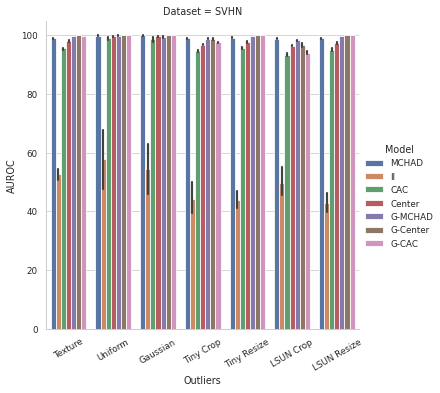

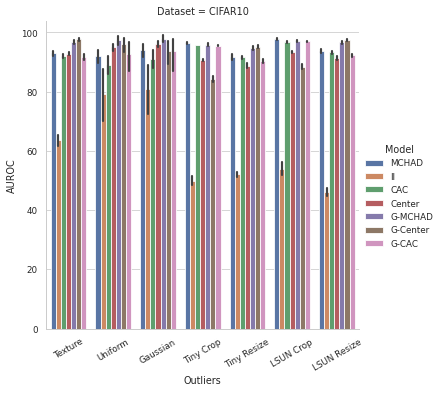

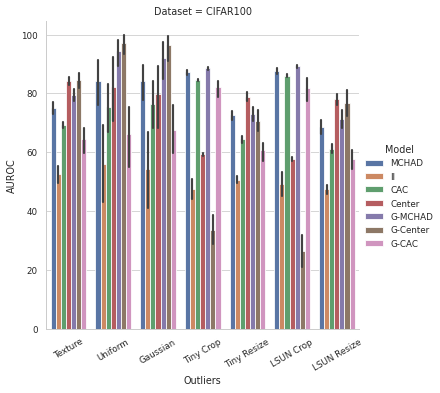

In [17]:
methods = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]
# ,
for dataset in ["SVHN", "CIFAR10", "CIFAR100"]:
    g = sb.catplot(
        data=df.reset_index()[df.reset_index()["Dataset"] == dataset],
        x="Outliers",
        y="AUROC",
        kind="bar",
        hue="Model",
        col="Dataset",
        hue_order=methods
    )
    g.set_xticklabels(rotation=30)
    # plt.tight_layout()
    plt.savefig(f"out/single-auroc-{dataset}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [13]:
tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")| (tmp["Model"] == "G-CAC") | (tmp["Model"] == "G-Center")]

print(
    tmp
    .groupby(by=["Dataset", "Model"])
    .agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    )
    .to_html(
        float_format="%.2f",
        escape=False,
    )
)


<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="2" halign="left">Accuracy</th>
      <th colspan="2" halign="left">AUROC</th>
      <th colspan="2" halign="left">AUPR-IN</th>
      <th colspan="2" halign="left">AUPR-OUT</th>
      <th colspan="2" halign="left">FPR95</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
    </tr>
    <tr>
      <th>Dataset</th>
      <th>Model</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="7" valign="top">CIFAR10</th>
      <th>CAC</th>
      <td>95.17</td>
      <td>0.01</td>
      <td>92.81</td>
      <td>0.38</td>
      <td>8

In [14]:
tmp.groupby(by=["Dataset", "Model"]).agg(
    {
        "Accuracy": ["mean", "sem"],
        "AUROC": ["mean", "sem"],
        "AUPR-IN": ["mean", "sem"],
        "AUPR-OUT": ["mean", "sem"],
        "FPR95": ["mean", "sem"],
    }
)

Accuracy                AUROC              AUPR-IN  \
                        mean       sem       mean       sem       mean   
Dataset  Model                                                           
CIFAR10  CAC       95.167143  0.012925  92.805612  0.384069  88.136066   
         Center    94.447619  0.014477  92.594731  0.245171  88.927594   
         G-CAC     94.975715  0.032037  93.325122  0.590605  90.334342   
         G-Center  94.281905  0.015007  93.294293  0.514628  89.272317   
         G-MCHAD   94.687143  0.012791  96.689627  0.186214  94.311822   
         II        28.405714  0.191769  60.832562  1.410953  59.177155   
         MCHAD     94.826191  0.016585  94.146536  0.315303  89.612503   
CIFAR100 CAC       75.674763  0.021189  73.846240  1.123284  68.815595   
         Center    76.592857  0.019610  74.262332  1.412159  69.035987   
         G-CAC     69.989524  0.936801  68.668704  1.344479  64.878456   
         G-Center  67.936190  0.107503  69.382736  2.352795  75.339109   
         G-MCHAD   77.135714  0.022373  83.956079  0.972355  80.560117   
         II         5.896667  0.069164  51.052665  1.464730  50.555481   
         MCHAD     77.519524  0.016811  79.877121  0.969785  72.586602   
SVHN     CAC       94.564748  0.030979  95.969863  0.182816  89.051910   
         Center    96.061441  0.009684  97.959086  0.108320  94.146987   
         G-CAC     94.224690  0.030045  98.767155  0.179194  97.839928   
         G-Center  95.870833  0.008824  99.325645  0.109678  98.291188   
         G-MCHAD   95.693396  0.007676  99.381552  0.052088  97.237543   
         II        10.589897  0.114472  49.318452  1.247567  27.948107   
         MCHAD     95.808272  0.012008  99.224693  0.043850  97.119255   

                              AUPR-OUT                FPR95            
                        sem       mean       sem       mean       sem  
Dataset  Model                                                         
CIFAR10  CAC       0.768479  94.837356  0.233450  18.871020  0.759963  
         Center    0.355282  92.656720  0.375121  29.752381  1.577260  
         G-CAC     0.717992  94.779941  0.418674  19.947415  1.182481  
         G-Center  0.825768  94.767527  0.400140  19.192721  1.190569  
         G-MCHAD   0.396759  97.568794  0.134912  10.273673  0.516653  
         II        1.335259  63.235131  1.466426  78.182313  2.414626  
         MCHAD     0.653051  95.800015  0.222384  16.181769  0.796295  
CIFAR100 CAC       1.242515  77.897029  0.969185  59.909048  1.923906  
         Center    1.371039  78.162300  1.249714  57.642789  2.320804  
         G-CAC     1.320360  73.198753  1.108712  66.948980  1.845620  
         G-Center  1.700284  69.520896  2.038682  66.749728  3.398424  
         G-MCHAD   1.025211  86.265850  0.898661  45.172381  2.376402  
         II        1.107358  55.791599  1.267906  86.722381  1.879308  
         MCHAD     1.113088  84.178454  0.806240  48.827143  2.045484  
SVHN     CAC       0.442728  97.678924  0.138491  14.601129  1.022428  
         Center    0.239554  98.894340  0.079013   6.347891  0.314782  
         G-CAC     0.314068  99.123353  0.134985   5.671878  0.968231  
         G-Center  0.283065  99.694234  0.051898   2.599600  0.408591  
         G-MCHAD   0.240523  99.796054  0.018058   2.141425  0.181102  
         II        1.000673  74.651407  0.800221  86.416195  1.643138  
         MCHAD     0.144737  99.739055  0.015691   3.163480  0.195883

In [15]:
from scipy.stats import ttest_ind

tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")]

for metric in ["Accuracy", "AUROC", "AUPR-IN", "AUPR-OUT", "FPR95"]:
    for dataset in ["SVHN", "CIFAR10", "CIFAR100"]:
        a = tmp[(tmp["Model"] == "CAC") & (tmp["Dataset"] == dataset)][metric]
        b = tmp[(tmp["Model"] == "MCHAD") & (tmp["Dataset"]== dataset)][metric]
        stat, p = ttest_ind(a,b, equal_var=False)
        print(f"{metric} {dataset} -> {p < 0.05} ")


Accuracy SVHN -> True 
Accuracy CIFAR10 -> True 
Accuracy CIFAR100 -> True 
AUROC SVHN -> True 
AUROC CIFAR10 -> True 
AUROC CIFAR100 -> True 
AUPR-IN SVHN -> True 
AUPR-IN CIFAR10 -> False 
AUPR-IN CIFAR100 -> True 
AUPR-OUT SVHN -> True 
AUPR-OUT CIFAR10 -> True 
AUPR-OUT CIFAR100 -> True 
FPR95 SVHN -> True 
FPR95 CIFAR10 -> True 
FPR95 CIFAR100 -> True 
